In [1]:
import pandas as pd
import scipy.io as io
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from matplotlib import gridspec
import seaborn as sns
import pingouin as pg
import copy

In [2]:
from scipy import stats
from scipy import sparse

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/srj34/deeplabcut-env/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
from functools import partial

In [4]:
import mne
from mne.stats import (ttest_1samp_no_p, bonferroni_correction, fdr_correction,
                       permutation_t_test, permutation_cluster_1samp_test)


In [5]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
import matplotlib.pyplot as plt
font = {'family': 'sans-serif', 'serif': ['Helvetica']}
plt.rc('font', **font)
plt.rc('text', usetex=False)

In [7]:
label_fontsize = 16 
title_fontsize = 18

In [8]:
sns.set(style="ticks", rc={"lines.linewidth": 0.6})

In [9]:
basefolder = "/rds/project/tb419/rds-tb419-bekinschtein/Sri/SpatialAttention_Drowsiness/"
inputfolderpath = basefolder + "drosSleepStages_SciAdvances2023/data/thermogenetic_data/"

In [10]:
outputfolderpath = basefolder + "SleepOnset_Drosophila/Scripts/pics/stats_grouplevel/"

In [11]:
def computegrpdata(basefilelist):
    
    diff_list = []
    group_cat1 = []
    group_cat2 = []
    group_cat3 = []
    group_cat1size = []
    group_cat2size = []
    group_cat3size = []
    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]
        print('Processing: ', basefilename)

        inputfilepath = inputfolderpath + "Spectrum_differential_ref_" + basefilename + ".mat"

        #Load the spectrum data from some samples..
        mat_spectrum = io.loadmat(inputfilepath)

        cat1_mean = (mat_spectrum['chan_cat1_mean'])
        cat2_mean = (mat_spectrum['chan_cat2_mean'])
        cat3_mean = (mat_spectrum['chan_cat3_mean'])

        cat1_size = np.asscalar(mat_spectrum['cat1_size'])
        cat2_size = np.asscalar(mat_spectrum['cat2_size'])
        cat3_size = np.asscalar(mat_spectrum['cat3_size'])

        cat1_se = mat_spectrum['chan_cat1_se']
        cat2_se = mat_spectrum['chan_cat2_se']
        cat3_se = mat_spectrum['chan_cat3_se']

        cat_freqs = mat_spectrum['freqs_state']
        cat_state = np.hstack(mat_spectrum['condition'].flatten()).tolist()

        if (len(cat1_mean)>0 and len(cat2_mean))>0:
            if (cat1_size >=1 and cat2_size >= 1):
                diff_cat = cat2_mean - cat1_mean
                #diff_cat = cat2_mean/cat1_mean - cat3_mean/cat1_mean
                diff_list.append(diff_cat)
                group_cat1.append(cat1_mean)
                group_cat2.append(cat2_mean)

                group_cat1size.append(cat1_size)
                group_cat2size.append(cat2_size)

                print("Cat1: ", cat_state[0],  " -- size: " + str(cat1_size))
                print("Cat2: ", cat_state[1],  " -- size: " + str(cat2_size))

                if cat3_size:
                    group_cat3.append(cat3_mean)
                    group_cat3size.append(cat3_size)
                    print("Cat3: ", cat_state[2],  " -- size: " + str(cat3_size))


            else:
                print("Skipping: " + "Spectrum_differential_ref_" + basefilename + ".mat")
        else:
            print("Skipping: " + "Spectrum_differential_ref_" + basefilename + ".mat")
            
            
    diff_group = np.array(diff_list)
    
    group_cat1 = np.array(group_cat1)
    group_cat1size = np.array(group_cat1size)
    group_cat2 = np.array(group_cat2)
    group_cat2size = np.array(group_cat2size)
    group_cat3 = np.array(group_cat3)
    group_cat3size = np.array(group_cat3size)
    
    group_cat1mean = np.median(group_cat1, axis = 0)
    group_cat2mean = np.median(group_cat2, axis = 0)
    group_cat3mean = np.median(group_cat3, axis = 0)
    
    diff_groupmean = np.median(diff_group, axis = 0)
    
    n_subjects = diff_group.shape[0]
    print('number of subjects considered: ', str(n_subjects))
    
    return diff_group,group_cat1,group_cat1size,group_cat2,group_cat2size,group_cat3,group_cat3size,\
           group_cat1mean,group_cat2mean,group_cat3mean,diff_groupmean, n_subjects, cat_freqs

In [12]:
def plot_spect(data, ax, x, y, x_label, y_label, title, vmin = None, vmax = None):
    
    im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
    
    y_mod = np.concatenate(y)
    freqs_plot = [6, 12, 18, 24, 30, 36, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
        

#     yticklocs = np.arange(0,len(y)-1, step = 4)
    ax.set_yticks(yticklocs)
    ax.set_yticklabels(np.around(np.concatenate(y[yticklocs])))
    
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    ax.set_xlim([0, np.asarray(x.shape)-1])
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    plt.xticks(xticklocs, tickval)
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)
    ax.set_ylabel(y_label, rotation=90,ha='center',va='center', fontsize=20, labelpad=20)
    
    ax.invert_yaxis()
    
    plt.colorbar(im)
    
    plt.title(title,ha='center',va='bottom', fontsize=20)

    return ax

In [13]:
def computestats(diff_group, n_subjects):
    
    X = diff_group
    tempX = copy.deepcopy(X)
    
    temp_subj, temp_freq, temp_chan  = tempX.shape
    n_src = temp_freq*temp_chan
    tempX.shape = (n_subjects, n_src)  # flatten the array for simplicity
    
    sigma = 1e-3  # sigma for the "hat" method
    maxperm = permutation_t_test(tempX, verbose=False)[:2]
    
    # connectivity matrix contains zeros and ones to define which spatial points are connected, 
    # i.e., which electrodes are adjacent to each other
    
                               #1 2  3  4  5  6  7  8  9  10 11 12 13 14 15,
    connectivity =  np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#1
                              [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#2
                              [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#3
                              [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],#4
                              [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],#5
                              [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],#6
                              [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],#7
                              [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],#8
                              [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],#9
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],#10
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],#11
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],#12
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],#13
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],#14
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]) #15
    
    conn_sparse=sparse.csr_matrix(connectivity)
    
    alpha = 0.05
    n_permutations = 'all'
    threshold = -stats.distributions.t.ppf(alpha / 2., n_subjects - 1)
    
    stat_fun_hat = partial(ttest_1samp_no_p, sigma=sigma)
    t_hat, clusters, p_values, H0 = permutation_cluster_1samp_test(X, n_jobs=1, threshold=threshold, 
                                                                   adjacency=conn_sparse,
                                                                   n_permutations=n_permutations, 
                                                                   stat_fun=stat_fun_hat, buffer_size=None)
    
    p_hat = np.ones((temp_freq, temp_chan))
    for cl, p in zip(clusters, p_values):
        p_hat[cl] = p
        
    contourmask = np.where(p_hat<alpha, 1, 0)
    mask = np.where(p_hat<alpha, 1, np.nan)
    
    contourmask2 = np.where(p_hat<alpha, 0, 1)
    
    return mask, contourmask, contourmask2

In [14]:
def computegroup_roi_cats(basefilelist):
    
    group_roi_cat1 = []
    group_roi_cat2 = []
    group_roi_cat3 = []
    
    for basefileidx in range(len(basefilelist)): #len(basefilelist)
        basefilename = basefilelist[basefileidx]
        print('Processing: ', basefilename)

        inputfilepath = inputfolderpath + "Spectrum_differential_ref_" + basefilename + ".mat"

        #Load the spectrum data from some samples..
        mat_spectrum = io.loadmat(inputfilepath)

        cat1_mean = (mat_spectrum['chan_cat1_mean'])
        cat2_mean = (mat_spectrum['chan_cat2_mean'])
        cat3_mean = (mat_spectrum['chan_cat3_mean'])

        cat1_size = np.asscalar(mat_spectrum['cat1_size'])
        cat2_size = np.asscalar(mat_spectrum['cat2_size'])
        cat3_size = np.asscalar(mat_spectrum['cat3_size'])

        cat1_se = mat_spectrum['chan_cat1_se']
        cat2_se = mat_spectrum['chan_cat2_se']
        cat3_se = mat_spectrum['chan_cat3_se']

        cat_freqs = mat_spectrum['freqs_state']
        cat_state = np.hstack(mat_spectrum['condition'].flatten()).tolist()


        roi_cat1 = np.ma.MaskedArray(cat1_mean,contourmask2)
        roi_cat1mean = roi_cat1.mean()
        roi_cat2 = np.ma.MaskedArray(cat2_mean,contourmask2)
        roi_cat2mean = roi_cat2.mean()
        if cat3_size:
            roi_cat3 = np.ma.MaskedArray(cat3_mean,contourmask2)
            roi_cat3mean = roi_cat3.mean()


        if (len(cat1_mean)>0 and len(cat2_mean))>0:
            if (cat1_size >=1 and cat2_size >= 1):

                group_roi_cat1.append(roi_cat1mean)
                group_roi_cat2.append(roi_cat2mean)
                if cat3_size:
                    group_roi_cat3.append(roi_cat3mean)

                #print("Cat1: ", cat_state[0],  " -- size: " + str(cat1_size))
                #print("Cat2: ", cat_state[1],  " -- size: " + str(cat2_size))
                #print("Cat3: ", cat_state[2],  " -- size: " + str(cat3_size))

            else:
                print("Skipping: " + "Spectrum_differential_ref_" + basefilename + ".mat")
        else:
            print("Skipping: " + "Spectrum_differential_ref_" + basefilename + ".mat")
            
    return group_roi_cat1, group_roi_cat2, group_roi_cat3

In [15]:
def plot_clustermask(data, ax, x, y, x_label, y_label, title, contourmask = None, mask = None, vmin = None, vmax = None, cmap = 'jet'):
    
    
    xticklocs = np.arange(0,np.asarray(x.shape), step = 2)
    tickval = np.arange(1,np.asarray(x.shape)+1, step = 2)
    
    
    if mask is not None:
        
        extent = [-0.55, len(x)-0.55, -0.55, len(y)-0.55]  
        im_args = dict(interpolation='nearest', origin='lower',extent=extent, aspect='auto', vmin=vmin, vmax=vmax)
        
        
        big_mask = np.kron(contourmask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["black"], extent=extent,linewidths=[.5], corner_mask=False,antialiased=True, levels=[0.5])
        masked_data = data*mask

        im1 = ax.imshow(masked_data,aspect='auto',interpolation='none',cmap=cmap,vmin=vmin, vmax=vmax, alpha = 0.5)
        fig.colorbar(im1, ax=ax)

    else:
        im = ax.imshow(data,aspect='auto',interpolation='spline36',cmap='jet',vmin=vmin, vmax=vmax)
        
    
    ax.set_xlim([0, np.asarray(x.shape)-1])
    
    
    y_mod = np.concatenate(y)
    freqs_plot = [6, 12, 18, 24, 30, 35, 40]
    yticklocs = []
    for idx in freqs_plot:
        yticklocs.append(min(range(len(y_mod)), key=lambda i: abs(y_mod[i]-idx)))
    

    ytickvals = np.around(np.concatenate(y[yticklocs]))
    
    ydispvals = ['%.12g' % n for n in ytickvals]
    
    plt.yticks(yticklocs, ydispvals)
    
    ax.invert_yaxis()
    
    ax.set_xticks(xticklocs)
    ax.set_xticklabels(tickval)
    
    ax.set_xlabel(x_label, rotation=0,ha='center',va='center', fontsize=20, labelpad=20)
    ax.set_ylabel(y_label, ha='center',va='center', fontsize=20, labelpad=20)
    
    plt.title(title,ha='center',va='bottom', fontsize=20)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
   
    return ax

## TrpA1

In [16]:
basefilelist = [ "dataset_08_104y_TrpA1",
                 "dataset_09_104y_TrpA1",
                 "dataset_10_104y_TrpA1",
                 "dataset_11_104y_TrpA1",
                 "dataset_13_104y_TrpA1",
                 "dataset_14_104y_TrpA1",
                 "dataset_15_104y_TrpA1",
               ]
figstrg = '104y_TrpA1_1sec_spectogram_stats'

In [17]:
n_flies = len(basefilelist)
print("Total files considered: " + str(n_flies))

Total files considered: 7


In [18]:
diff_group,group_cat1,group_cat1size,group_cat2,group_cat2size,group_cat3,group_cat3size,\
           group_cat1mean,group_cat2mean,group_cat3mean,diff_groupmean, n_subjects, cat_freqs =\
           computegrpdata(basefilelist)

Processing:  dataset_08_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_09_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_10_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_11_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_13_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_14_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_15_104y_TrpA1
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
number of subjects considered:  7


In [19]:
mask, contourmask, contourmask2 = computestats(diff_group, n_subjects)

stat_fun(H1): min=-2.797819 max=5.438868
Running initial clustering
Found 5 clusters
Permuting 62 times...



Computing cluster p-values
Done.


In [20]:
group_roi_cat1, group_roi_cat2, group_roi_cat3 = computegroup_roi_cats(basefilelist)

Processing:  dataset_08_104y_TrpA1
Processing:  dataset_09_104y_TrpA1
Processing:  dataset_10_104y_TrpA1
Processing:  dataset_11_104y_TrpA1
Processing:  dataset_13_104y_TrpA1
Processing:  dataset_14_104y_TrpA1
Processing:  dataset_15_104y_TrpA1


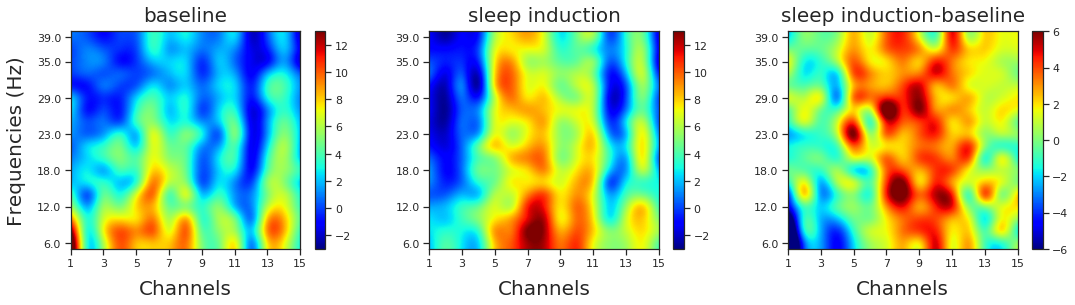

In [21]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat1mean, ax = ax1, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = 'baseline', #cat_state[0]
                 vmin = -3, vmax = 13) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat2mean, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = 'sleep induction',#cat_state[1]
                 vmin = -3, vmax = 13) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', 
                 title = 'sleep induction' + '-' + 'baseline',#cat_state[1] + '-' + cat_state[0]
                 vmin = -6, vmax = 6) #vmin = -6, vmax = 6,vmin = 0, vmax = 10

plt.savefig(outputfolderpath +  figstrg + '.png', format='png', dpi=300, transparent=False,bbox_inches='tight')

In [22]:
typepal = {'PreHeat':'r', 'HeatOn': 'b'}

In [23]:
group_roi_df = pd.DataFrame({'PreHeat': group_roi_cat1, 'HeatOn': group_roi_cat2})
group_roi_df['dataset'] = group_roi_df.index
group_roi_df = group_roi_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [24]:
group_roi_df

,dataset,type,power
0,0,PreHeat,8.663064
1,1,PreHeat,-2.508504
2,2,PreHeat,3.610944
3,3,PreHeat,2.042424
4,4,PreHeat,3.449310
5,5,PreHeat,5.913851
6,6,PreHeat,-1.499610
7,0,HeatOn,7.975122
8,1,HeatOn,3.114084
9,2,HeatOn,6.491599


In [25]:
mask_empty = np.all((contourmask == 0))

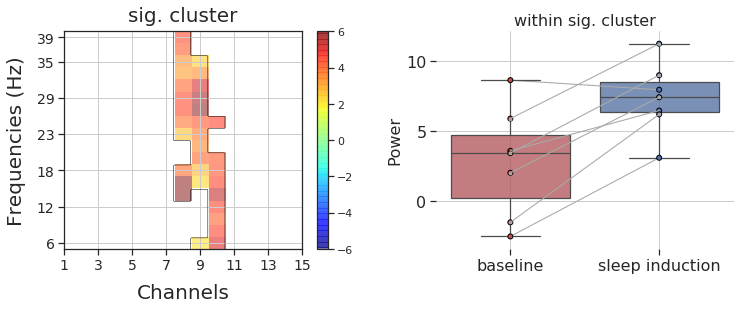

In [26]:
fig = plt.figure(figsize=(6*2, 4))
gs_main = gridspec.GridSpec(1, 2,width_ratios=[4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_clustermask(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                       x_label = 'Channels', y_label = 'Frequencies (Hz)', title = 'sig. cluster',
                       contourmask = contourmask, mask = mask, 
                       vmin = -6, vmax = 6) #vmin = 0, vmax = 10

ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)

ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])

if ~mask_empty:

    ax2 = fig.add_subplot(gs[0])
    sns.boxplot(x="type",y="power",data = group_roi_df, whis=np.inf, ax=ax2, showbox=True,dodge=False,
                meanline=True,showmeans=False, showfliers=True,showcaps=True, 
                linewidth = 1.25, palette = typepal)

    sns.pointplot(x="type",y="power",hue='dataset',data=group_roi_df,ax=ax2, dodge=0.0,
                        palette=['darkgray'])

    sns.stripplot(x="type",y="power",data = group_roi_df, jitter=False, linewidth=1, ax=ax2,
                  edgecolor ="black",palette=typepal)
    
    ax2.grid(True)
    ax2.set_xticklabels(["baseline","sleep induction"])

 
    ax2.legend_.remove()
    b = list(ax2.get_children())

    for patch in ax2.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
        
    ax2.set_ylabel('Power', fontsize=label_fontsize)
    ax2.set_xlabel('', fontsize=label_fontsize)
    ax2.set_title('within sig. cluster', fontsize=label_fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)
    

# plt.tight_layout()
plt.box(False)

plt.savefig(outputfolderpath +  figstrg + '_cluster' + '.png', format='png', dpi=300, transparent=False,
            bbox_inches='tight')

## Gal4control

In [27]:
basefilelist = [ "dataset_01_104y_GAL4Control",
                 "dataset_02_104y_GAL4Control",
                 "dataset_03_104y_GAL4Control",
                 "dataset_04_104y_GAL4Control",
                 "dataset_05_104y_GAL4Control",
                 "dataset_06_104y_GAL4Control",
                 "dataset_07_104y_GAL4Control",
               ]
figstrg = '104y_GAL4Control_1sec_spectogram_stats'

In [28]:
n_flies = len(basefilelist)
print("Total files considered: " + str(n_flies))

Total files considered: 7


In [29]:
diff_group,group_cat1,group_cat1size,group_cat2,group_cat2size,group_cat3,group_cat3size,\
           group_cat1mean,group_cat2mean,group_cat3mean,diff_groupmean, n_subjects, cat_freqs =\
           computegrpdata(basefilelist)

Processing:  dataset_01_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_02_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_03_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_04_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_05_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_06_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
Processing:  dataset_07_104y_GAL4Control
Cat1:  PreHeat  -- size: 3
Cat2:  HeatOn  -- size: 3
Cat3:  HeatOff  -- size: 3
number of subjects considered:  7


In [30]:
mask, contourmask, contourmask2 = computestats(diff_group, n_subjects)

stat_fun(H1): min=-2.727330 max=4.053564
Running initial clustering
Found 12 clusters
Permuting 62 times...



Computing cluster p-values
Done.


In [31]:
group_roi_cat1, group_roi_cat2, group_roi_cat3 = computegroup_roi_cats(basefilelist)

Processing:  dataset_01_104y_GAL4Control
Processing:  dataset_02_104y_GAL4Control
Processing:  dataset_03_104y_GAL4Control
Processing:  dataset_04_104y_GAL4Control
Processing:  dataset_05_104y_GAL4Control
Processing:  dataset_06_104y_GAL4Control
Processing:  dataset_07_104y_GAL4Control


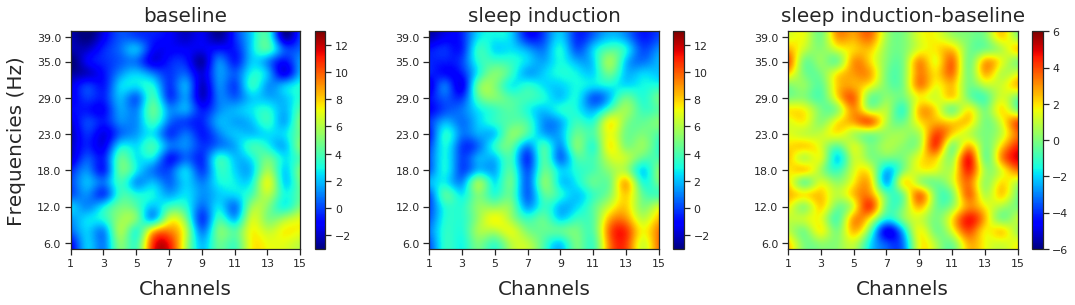

In [32]:
fig = plt.figure(figsize=(6*3, 4))
gs_main = gridspec.GridSpec(1, 3,width_ratios=[4,4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_spect(group_cat1mean, ax = ax1, x = np.arange(0,group_cat1.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = 'Frequencies (Hz)', title = 'baseline', #cat_state[0]
                 vmin = -3, vmax = 13) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])
ax2 = fig.add_subplot(gs[0])
ax2 = plot_spect(group_cat2mean, ax = ax2, x = np.arange(0,group_cat2.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', title = 'sleep induction',#cat_state[1]
                 vmin = -3, vmax = 13) #vmin = -3, vmax = 13

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[2])
ax3 = fig.add_subplot(gs[0])
ax3 = plot_spect(diff_groupmean, ax = ax3, x = np.arange(0,diff_group.shape[2]), y = cat_freqs, 
                 x_label = 'Channels',y_label = '', 
                 title = 'sleep induction' + '-' + 'baseline',#cat_state[1] + '-' + cat_state[0]
                 vmin = -6, vmax = 6) #vmin = -6, vmax = 6,vmin = 0, vmax = 10

plt.savefig(outputfolderpath +  figstrg + '.png', format='png', dpi=300, transparent=False,bbox_inches='tight')

In [33]:
typepal = {'PreHeat':'r', 'HeatOn': 'b'}

In [34]:
group_roi_df = pd.DataFrame({'PreHeat': group_roi_cat1, 'HeatOn': group_roi_cat2})
group_roi_df['dataset'] = group_roi_df.index
group_roi_df = group_roi_df.melt(id_vars=["dataset"], var_name="type", value_name="power")

In [35]:
group_roi_df

,dataset,type,power
0,0,PreHeat,--
1,1,PreHeat,--
2,2,PreHeat,--
3,3,PreHeat,--
4,4,PreHeat,--
5,5,PreHeat,--
6,6,PreHeat,--
7,0,HeatOn,--
8,1,HeatOn,--
9,2,HeatOn,--


In [36]:
mask_empty = np.all((contourmask == 0))

/home/srj34/deeplabcut-env/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


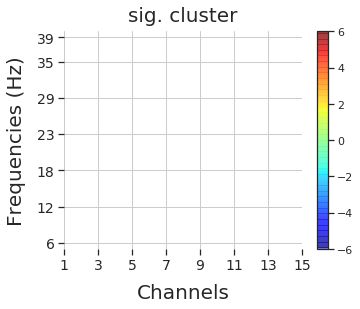

In [37]:
fig = plt.figure(figsize=(6*2, 4))
gs_main = gridspec.GridSpec(1, 2,width_ratios=[4,4])
gs_main.update(wspace=0.25, hspace=0.2)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[0])
ax1 = fig.add_subplot(gs[0])
ax1 = plot_clustermask(diff_groupmean, ax = ax1, x = np.arange(0,diff_group.shape[2]), y = cat_freqs,
                       x_label = 'Channels', y_label = 'Frequencies (Hz)', title = 'sig. cluster',
                       contourmask = contourmask, mask = mask, 
                       vmin = -6, vmax = 6) #vmin = 0, vmax = 10

ax1.tick_params(axis='both', which='major', labelsize=label_fontsize-2)
ax1.grid(True)

ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(True)
ax1.spines['left'].set_visible(True)
ax1.spines['bottom'].set_visible(True)

gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_main[1])

if ~mask_empty:

    ax2 = fig.add_subplot(gs[0])
    sns.boxplot(x="type",y="power",data = group_roi_df, whis=np.inf, ax=ax2, showbox=True,dodge=False,
                meanline=True,showmeans=False, showfliers=True,showcaps=True, 
                linewidth = 1.25, palette = typepal)

    sns.pointplot(x="type",y="power",hue='dataset',data=group_roi_df,ax=ax2, dodge=0.0,
                        palette=['darkgray'])

    sns.stripplot(x="type",y="power",data = group_roi_df, jitter=False, linewidth=1, ax=ax2,
                  edgecolor ="black",palette=typepal)
    
    ax2.grid(True)
    ax2.set_xticklabels(["baseline","sleep induction"])

 
    ax2.legend_.remove()
    b = list(ax2.get_children())

    for patch in ax2.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .8))
        
    ax2.set_ylabel('Power', fontsize=label_fontsize)
    ax2.set_xlabel('', fontsize=label_fontsize)
    ax2.set_title('within sig. cluster', fontsize=label_fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=label_fontsize)
    

# plt.tight_layout()
plt.box(False)

plt.savefig(outputfolderpath +  figstrg + '_cluster' + '.png', format='png', dpi=300, transparent=False,
            bbox_inches='tight')